# Cosine Quantogram Analysis and Monte Carlo simulation

In [1]:
# Import libraries
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math
from scipy import stats
import seaborn as sns

In [2]:
# Read data from the Excel file 'DB_SI.xlsx' and store it in the DataFrame
db_original=pd.read_excel('DB_SI.xlsx')

# Filter the DataFrame to select only rows where 'complete/fragmented/undetermined' is 'fragment'
db_original = db_original.loc[(db_original['complete/fragmented/undetermined'] == 'fragment')].copy()

db = (db_original['Weight_obj'])

# Define the minimum and maximum values for data samples and quantum, as well as the step size.
min_data_sample = 7
max_data_sample = 200
min_quantum = 2
max_quantum = 16
step = 0.02

In [3]:
# Filter the 'db' DataFrame to select values between min_data_sample and max_data_sample
db_2_analyse = db[(db >= min_data_sample) & (db < max_data_sample)]

# Drop any NaN values in the filtered DataFrame and assign it to a new variable 'df'
df=db_2_analyse.dropna()
df = pd.DataFrame({'Filtered Values': db_2_analyse.dropna()})

In [4]:
# Create an array of quantum values ranging from min_quantum to max_quantum with the specified step size
quanta_arr = np.arange(min_quantum, max_quantum + step, step)

# Create a DataFrame 'quanta' with the 'Quanta_val' column containing the generated quantum values
quanta = pd.DataFrame({'Quanta_val': quanta_arr})

**CQA**

In [5]:
# Create empty DataFrames to store the results
reminder = pd.DataFrame()
cosine_results = pd.DataFrame()
phi_q_df = pd.DataFrame()

# Calculate the sample size and the coefficient used in the calculations
sample_size = df.count()
coeff = 2 / sample_size
sample_coefficient = np.sqrt(coeff).iloc[0]

# Calculate the reminders for each quantum value and concatenate them into the 'reminder' DataFrame
reminder = pd.concat([df.iloc[:, 0] % q for q in quanta_arr], axis=1)
reminder.columns = [round(q, 2) for q in quanta_arr]

# Calculate cosine results and concatenate them into the 'cosine_results' DataFrame
cosine_results = pd.concat([(2 * math.pi * df.iloc[:, 0]) / q for q in quanta_arr], axis=1)
cosine_results.columns = [f'Results {round(q, 2)}' for q in quanta_arr]
cosine_results = np.cos(cosine_results)

# Calculate the sum of cosine results along the columns (axis=0) to obtain a series
cosine_sum_series = cosine_results.sum(axis=0)

# Convert the cosine sum series to a DataFrame with a single column
cosine_sum = cosine_sum_series.to_frame()

# Multiply the cosine sum values by the sample coefficient and store the results in phi_q_df
phi_q_df = cosine_sum.multiply(sample_coefficient)

# Rename the column to 'Phi_q_values' and add a new column 'quanta' containing the quantum values
phi_q_df.columns = ['Phi_q_values']
phi_q_df['quanta'] = quanta_arr

#print(phi_q_df)


In [6]:
# Find the maximum value in the 'Phi_q_values' column of phi_q_df
max_value = phi_q_df['Phi_q_values'].max()

# Find the corresponding 'quanta' value for the maximum 'Phi_q_values'
quantum_max = phi_q_df.loc[phi_q_df['Phi_q_values'].idxmax(), 'quanta']

# Print the highest 'Phi_q_values' and the corresponding quantum value
print(f"Highest 'Phi_q_values': {max_value}")
print(f"Best quantum: {quantum_max}")

Highest 'Phi_q_values': 7.562389087865672
Best quantum: 9.800000000000008


**Monte Carlo**

In [7]:
# Define the Monte Carlo parameters
mc_parameter = 0.15
mc_iterations = 1000

# Create a copy of the original dataframe 'df'
df_copy=df

# Function to apply variation to the dataframe based on the Monte Carlo parameter
def apply_variation(df_copy, mc_parameter):
    percent_diff = df_copy * mc_parameter
    random_matrix = np.random.uniform(-1, 1, size=df_copy.shape)
    variations = random_matrix * percent_diff
    return df_copy + variations

final_mc_df = pd.DataFrame()

# Initialize an empty list to store intermediate dataframes
intermediate_dfs = []

# Perform Monte Carlo simulations
for i in range(mc_iterations):
    # Create a copy of the original dataframe for each iteration
    df_copy = df.copy()
    # Apply variation using the defined Monte Carlo parameter
    mc_df = apply_variation(df_copy, mc_parameter)
    # Append the first column (or only column) to the list
    intermediate_dfs.append(mc_df[df.columns[0]]) 
    
# Concatenate the intermediate dataframes to create the final Monte Carlo dataframe
final_mc_df = pd.concat(intermediate_dfs, axis=1)
final_mc_df.columns = [f'MC_{i+1}' for i in range(mc_iterations)]


#print(final_mc_df)

In [8]:
# Initialize an empty DataFrame called 'Montecarlo_phi_q'
Montecarlo_phi_q = pd.DataFrame()

def calculate_Phi_q_values_mc(df, quanta_arr):
    """
    Calculate Phi_q values for a given DataFrame and an array of quantum values.

    Parameters:
    - df: DataFrame containing input numerical data.
    - quanta_arr: NumPy array of quantum values.

    Returns:
    - Phi_q_values_mc_list: List of calculated Phi_q values corresponding to each quantum value in quanta_arr.
    """
    Phi_q_values_mc_list = []# Initialize an empty list to store calculated Phi_q values
    
    # Iterate through each quantum value in quanta_arr
    for q in quanta_arr:
        # Calculate the reminder for the current quantum value
        reminder_mc = df.iloc[:, 0] % q
        # Calculate the cosine result for the current quantum value
        cosine_result_mc = np.cos((2 * math.pi * df.iloc[:, 0]) / q)
        # Calculate the Phi_q value for the current quantum value and sum the results
        Phi_q_values_mc = np.sum(cosine_result_mc) * sample_coefficient
        # Append the calculated Phi_q value to the list
        Phi_q_values_mc_list.append(Phi_q_values_mc)
        
    return Phi_q_values_mc_list    # Return the list of calculated Phi_q values

# Initialize an empty list to store Montecarlo Phi_q values for each column
Montecarlo_phi_q_values = []
# Variable to track the number of completed columns
completed_cols = 0

# Iterate through each column in the final_mc_df DataFrame
for col in final_mc_df.columns:
    df = final_mc_df[[col]]  
    Phi_q_values_mc_list = calculate_Phi_q_values_mc(df, quanta_arr)
    Montecarlo_phi_q_values.append(Phi_q_values_mc_list)
    
    completed_cols += 1
    print(f"Column {completed_cols}/{mc_iterations} completed.")

# Create a DataFrame from the list of Montecarlo Phi_q values, with columns as quantum values
Montecarlo_phi_q = pd.DataFrame(Montecarlo_phi_q_values, columns=quanta_arr).T

print(Montecarlo_phi_q)

Column 1/1000 completed.
Column 2/1000 completed.
Column 3/1000 completed.
Column 4/1000 completed.
Column 5/1000 completed.
Column 6/1000 completed.
Column 7/1000 completed.
Column 8/1000 completed.
Column 9/1000 completed.
Column 10/1000 completed.
Column 11/1000 completed.
Column 12/1000 completed.
Column 13/1000 completed.
Column 14/1000 completed.
Column 15/1000 completed.
Column 16/1000 completed.
Column 17/1000 completed.
Column 18/1000 completed.
Column 19/1000 completed.
Column 20/1000 completed.
Column 21/1000 completed.
Column 22/1000 completed.
Column 23/1000 completed.
Column 24/1000 completed.
Column 25/1000 completed.
Column 26/1000 completed.
Column 27/1000 completed.
Column 28/1000 completed.
Column 29/1000 completed.
Column 30/1000 completed.
Column 31/1000 completed.
Column 32/1000 completed.
Column 33/1000 completed.
Column 34/1000 completed.
Column 35/1000 completed.
Column 36/1000 completed.
Column 37/1000 completed.
Column 38/1000 completed.
Column 39/1000 comple

Column 309/1000 completed.
Column 310/1000 completed.
Column 311/1000 completed.
Column 312/1000 completed.
Column 313/1000 completed.
Column 314/1000 completed.
Column 315/1000 completed.
Column 316/1000 completed.
Column 317/1000 completed.
Column 318/1000 completed.
Column 319/1000 completed.
Column 320/1000 completed.
Column 321/1000 completed.
Column 322/1000 completed.
Column 323/1000 completed.
Column 324/1000 completed.
Column 325/1000 completed.
Column 326/1000 completed.
Column 327/1000 completed.
Column 328/1000 completed.
Column 329/1000 completed.
Column 330/1000 completed.
Column 331/1000 completed.
Column 332/1000 completed.
Column 333/1000 completed.
Column 334/1000 completed.
Column 335/1000 completed.
Column 336/1000 completed.
Column 337/1000 completed.
Column 338/1000 completed.
Column 339/1000 completed.
Column 340/1000 completed.
Column 341/1000 completed.
Column 342/1000 completed.
Column 343/1000 completed.
Column 344/1000 completed.
Column 345/1000 completed.
C

Column 613/1000 completed.
Column 614/1000 completed.
Column 615/1000 completed.
Column 616/1000 completed.
Column 617/1000 completed.
Column 618/1000 completed.
Column 619/1000 completed.
Column 620/1000 completed.
Column 621/1000 completed.
Column 622/1000 completed.
Column 623/1000 completed.
Column 624/1000 completed.
Column 625/1000 completed.
Column 626/1000 completed.
Column 627/1000 completed.
Column 628/1000 completed.
Column 629/1000 completed.
Column 630/1000 completed.
Column 631/1000 completed.
Column 632/1000 completed.
Column 633/1000 completed.
Column 634/1000 completed.
Column 635/1000 completed.
Column 636/1000 completed.
Column 637/1000 completed.
Column 638/1000 completed.
Column 639/1000 completed.
Column 640/1000 completed.
Column 641/1000 completed.
Column 642/1000 completed.
Column 643/1000 completed.
Column 644/1000 completed.
Column 645/1000 completed.
Column 646/1000 completed.
Column 647/1000 completed.
Column 648/1000 completed.
Column 649/1000 completed.
C

Column 917/1000 completed.
Column 918/1000 completed.
Column 919/1000 completed.
Column 920/1000 completed.
Column 921/1000 completed.
Column 922/1000 completed.
Column 923/1000 completed.
Column 924/1000 completed.
Column 925/1000 completed.
Column 926/1000 completed.
Column 927/1000 completed.
Column 928/1000 completed.
Column 929/1000 completed.
Column 930/1000 completed.
Column 931/1000 completed.
Column 932/1000 completed.
Column 933/1000 completed.
Column 934/1000 completed.
Column 935/1000 completed.
Column 936/1000 completed.
Column 937/1000 completed.
Column 938/1000 completed.
Column 939/1000 completed.
Column 940/1000 completed.
Column 941/1000 completed.
Column 942/1000 completed.
Column 943/1000 completed.
Column 944/1000 completed.
Column 945/1000 completed.
Column 946/1000 completed.
Column 947/1000 completed.
Column 948/1000 completed.
Column 949/1000 completed.
Column 950/1000 completed.
Column 951/1000 completed.
Column 952/1000 completed.
Column 953/1000 completed.
C

In [9]:
# Calculate the number of iterations corresponding to 1% and 5% of total Monte Carlo iterations
alpha_1_share = round(mc_iterations * 0.01)
alpha_5_share = round(mc_iterations * 0.05)

# Find the maximum Phi_q value in each quantum column across Monte Carlo iterations
mc_max_column = Montecarlo_phi_q.max()

# Select the alpha_1-th largest Phi_q value (1% quantile) among all columns
alpha_1 = mc_max_column.nlargest(alpha_1_share).iloc[-1]

# Select the alpha_5-th largest Phi_q value (5% quantile) among all columns
alpha_5 = mc_max_column.nlargest(alpha_5_share).iloc[-1]

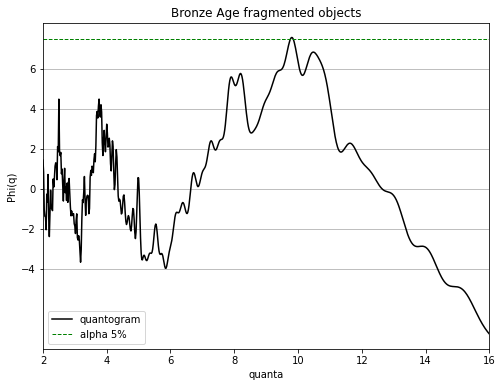

In [10]:
# Plotting 

fig, axes = plt.subplots(figsize=(8, 6))

sns.lineplot(data=phi_q_df, x=phi_q_df['quanta'], y=phi_q_df['Phi_q_values'], color='black', label='quantogram')
#plt.axhline(y=alpha_1, color='r', linestyle='--', label='alpha_1', linewidth=1)
plt.axhline(y=alpha_5, color='g', linestyle='--', label='alpha 5%', linewidth=1)
plt.xlim(quanta_arr[0], quanta_arr[-1])
plt.xticks([2, 4, 6, 8, 10, 12, 14, 16])
plt.yticks([-4, -2, 0, 2, 4, 6])

plt.ylabel('Phi(q)')
plt.title('Bronze Age fragmented objects')
plt.legend()
plt.grid(axis='y')

#plt.savefig('BA_Fragments.pdf', format='pdf')
plt.show()

In [11]:
alpha_5

7.47485990119831

In [12]:
#phi_q_df.to_excel('quantogram_values_complete.xlsx', index=False)